In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")


/home/greg/data/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
data_path = '~/data/current/NMEG_utils/processed_data/daily_aflx/'
fig_path = '../figures/multiyear_figs/'
# Years to load
start = 2007
end = 2015
sites = ['Seg', 'Ses', 'Sen', 'Wjs', 'Mpj', 'Mpg', 'Vcp', 'Vcm']
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_file( data_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Seg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Ses_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Sen_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Wjs_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpj_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcp_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcm_daily_aflx.csv


## Plot NEE timeseries

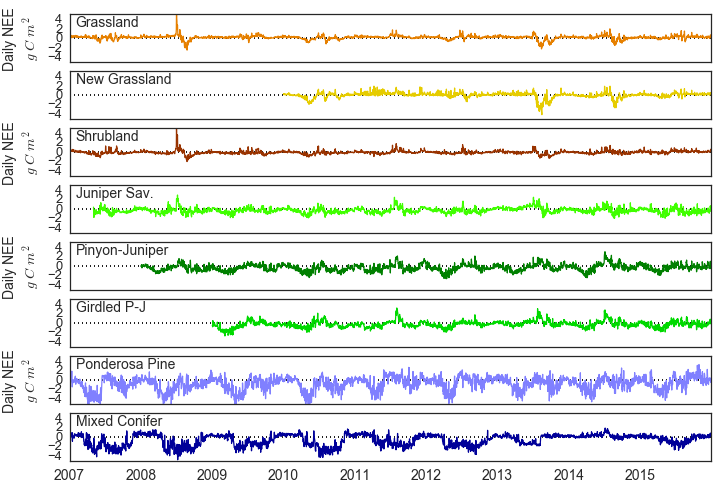

In [3]:
ylims = [ -5, 5 ]
fig1 = plt.figure(figsize=( 11.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'FC_F_g_int', 2.5, fig1, 'Daily NEE\n$g\ C\ m^2$', ylims=ylims)

#plt.show()
fig1.savefig( fig_path + 'NMEG_daily_FC.svg')
fig1.savefig( fig_path + 'NMEG_daily_FC.png', dpi=200)

## Plot partitioned timeseries

* GPP is negative

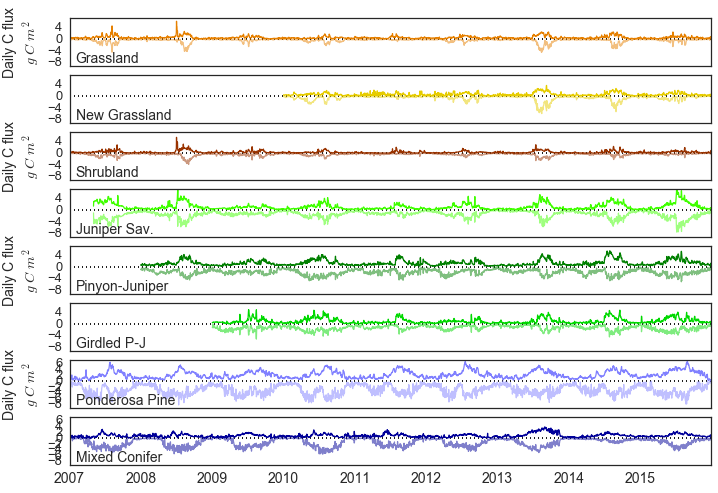

In [4]:
ylims = [ -9, 7 ]

fig2 = plt.figure(figsize=( 11.5, 8 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, ['RECO_g_int', 'GPP_g_int'], -8, fig2, 'Daily C flux\n$g\ C\ m^2$', ylims=ylims)
for j in range(0,6):
    ax[j].yaxis.set_ticks(np.arange(-8, 6, 4))

#plt.show()
fig2.savefig( fig_path + 'NMEG_daily_part.svg')
fig2.savefig( fig_path + 'NMEG_daily_part.png', dpi=200)

## Calculate multi-year statistics

Get multiyear descriptive stats (climatologies)

In [5]:
# Create dictionaries with modified climatology (see mod_clim)
# for each site
fc_clim = { s : tr.var_climatology( d[s].FC_F_g_int ) for s in sites}
gpp_clim = { s : tr.var_climatology( d[s].GPP_g_int ) for s in sites}
re_clim = { s :tr.var_climatology( d[s].RECO_g_int ) for s in sites}
p_clim = { s : tr.var_climatology( d[s].P_F_sum ) for s in sites}
vpd_clim = { s : tr.var_climatology( d[s].VPD_F_avg ) for s in sites}

fc_clim['Seg'].columns

Index(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', 'allyr_mean', 'allyr_stdev', 'allyr_stderr', 'allyr_cv',
       'allyr_cv2'],
      dtype='object')

### Set up plots

In [14]:
# Set x limits
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2015, 12, 31 )]

# Plot definition for one-site axis showing Multiyear mean + individual years in background
def plot_multiyr_lines( ax_in, clim, climcols, meancolor, 
                       syr=start, eyr=end, plterr=False,
                       indyrs=False, hilite=[None] ):
    if type(climcols) == type(str()):
        climcols = [climcols,]
        plterr = True
        meancolor = [meancolor,]
    else:
        meancolor = [meancolor,'red','gray']
            
    # If requested, plot individual years
    if indyrs: 
        for i in range( syr, eyr+1 ):
            # If requested, highlight a particular year in red
            if i in hilite:
                hicolour='Red'
            else:
                hicolour=[0.7, 0.7, 0.7]
            # Plot the individual year line (mean + anomaly)
            ax_in.plot(clim.index, clim[ str(i) ], 
                       color=hicolour, lw=0.5)
    #ls = ['-', '--', ':']
    for j, col in enumerate(climcols):
        if j > 0:
            ax_in.plot(clim.index, clim[col], color=meancolor[j], lw=0.5)
        else:
            ax_in.plot(clim.index, clim[col], color=meancolor[j])
        # Plot error of mean if requested
        if plterr:
            ax_in.plot(clim.index, clim[col] + clim.allyr_stderr, color=meancolor[j], alpha=.4)
            ax_in.plot(clim.index, clim[col] - clim.allyr_stderr, color=meancolor[j], alpha=.4)
    
# Plot definition for a 3 x 2 plot of multiyear mean fluxes
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, ind_yrs=False,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.longnames, colors=nmegplt.palette, hilite_yr=None ):
    # If input is a list RE is pos, GPP is neg
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
    # Loop through sites/subplots
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(len(sitelist)/2, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plot_multiyr_lines( ax[i], clim[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        # If requested plot a series negative (usually GPP)
        if type(clim_in) is list:
            plot_multiyr_lines( ax[i], -clim2[site], clim_cols, colors[site], hilite=[hilite_yr], indyrs=ind_yrs )
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[site], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < len(sitelist)-2:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in range(0, len(sitelist)-1, 2):
        ax[i].set_ylabel('Mean ' + varname + '\n$g\ C\ m^2$', fontsize=14)
        
    return ax

## Plot multiyear C flux means

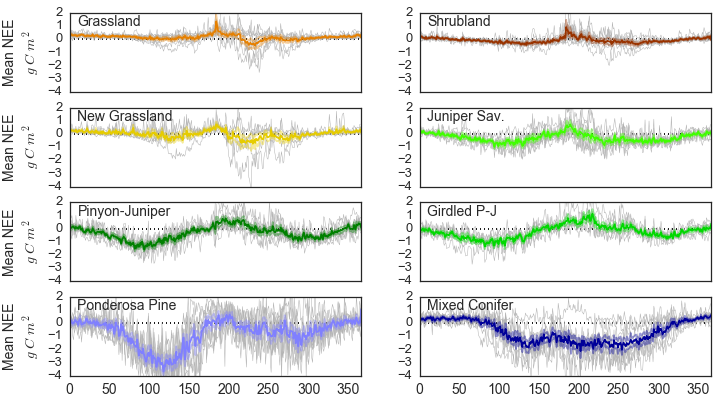

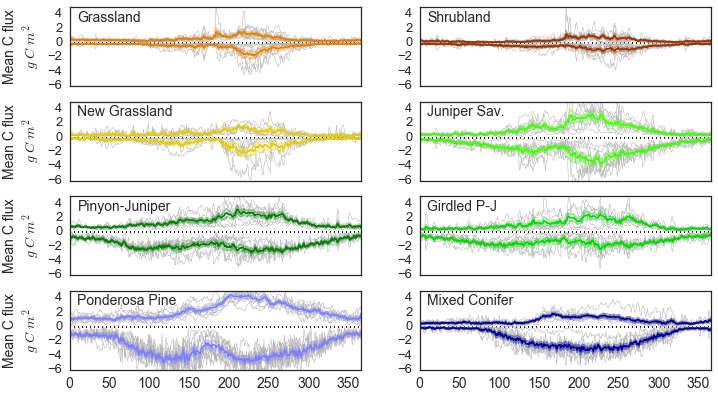

In [15]:
# Plot NEE
ylims = [ -4, 2 ]
xlims = [ 0, 366 ]
highlight_year = [2011]
fig3 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'allyr_mean', 'NEE', 1, fig3, ind_yrs=True,
                        ylims=ylims)     
fig3.savefig( fig_path + 'NMEG_mean_NEE.svg')
fig3.savefig( fig_path + 'NMEG_mean_NEE.png', dpi=200)


# Plot RECO and GPP
ylims = [ -6, 5 ]
fig6 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'allyr_mean', 'C flux', 3, fig6,
                        ylims=ylims, ind_yrs=True)
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.svg')
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.png', dpi=200)

## Cumulative sums by year

These show cumulative C flux (NEE or GPP) for each year measured.

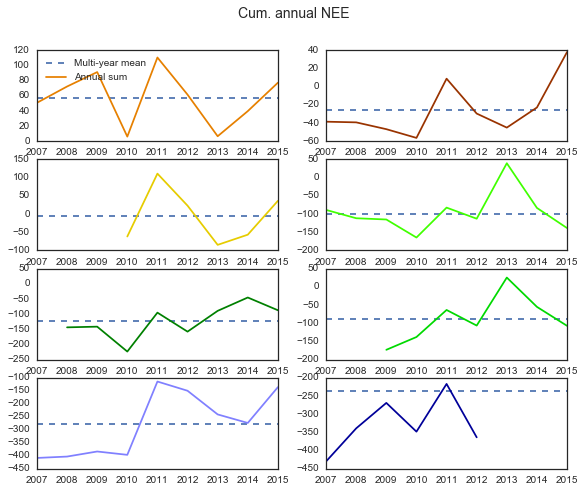

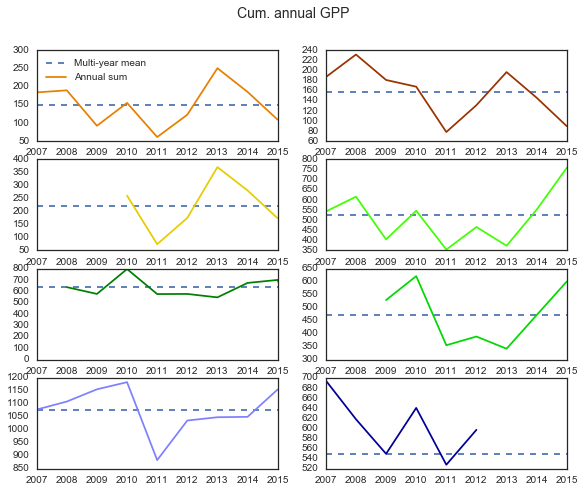

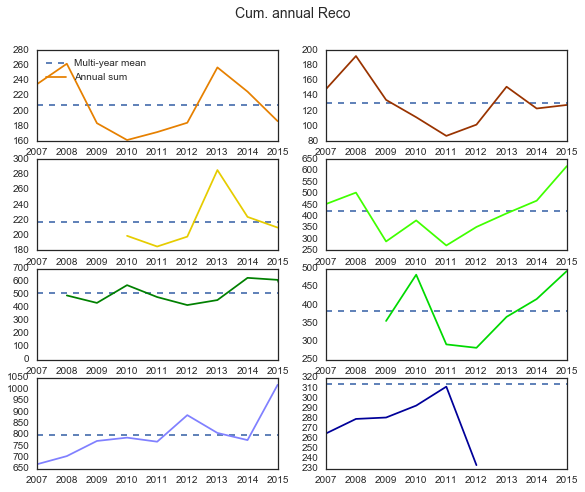

In [12]:
def plot_cumulative_annual( daily_var, clim, fig ):
    for i, site in enumerate(sites):
        ax = fig.add_subplot(len(sites)/2, 2, i+1)
        data = d[site][ daily_var ].groupby(d[site].index.year).sum()
        mean = clim[site].allyr_mean.sum()
        plt.plot([data.index[0], data.index[-1]], [mean, mean], ls='--')
        if site == 'Vcm':
            data = data[data.index < 2013]
        elif site == 'Mpj':
            data = data[data.index > 2007]  
        else:
            data = data[data.index < end+1]
        plt.plot(data.index, data, color=nmegplt.palette[site])
        
        if i == 0:
            plt.legend(['Multi-year mean', 'Annual sum'], loc='upper left')
        plt.xlim([start, end])
        x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)
        ax.xaxis.set_major_formatter(x_formatter)
        #print(data.GPP_g_int.sum())

figX = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'FC_F_g_int', fc_clim, figX )
plt.suptitle('Cum. annual NEE', size=14)

figY = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'GPP_g_int', gpp_clim, figY )
plt.suptitle('Cum. annual GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 7.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'RECO_g_int', re_clim, figZ )
plt.suptitle('Cum. annual Reco', size=14)

## Table of cumulative values

* Summed g C/m2 during the different periods we are interested in (pre-, post-, drought, and all year means)
* Differences between pre-drought/potential cumulative values and and drought/post-drought periods
* Percentage of pre-drought and potential cumulative flux


In [22]:
indices = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 
           'AllYr Mean', 'AllYr StdDev']
nee_t = pd.DataFrame(columns=sites, index = indices)
gpp_t = pd.DataFrame(columns=sites, index = indices)
reco_t = pd.DataFrame(columns=sites, index = indices)

for i, site in enumerate(sites):
        
    # Sum up the climatology columns for the site
    sums = fc_clim[site].sum()
    nee_t.loc['2007', site] = sums['2007']
    nee_t.loc['2008', site] = sums['2008']
    nee_t.loc['2009', site] = sums['2009']
    nee_t.loc['2010', site] = sums['2010']
    nee_t.loc['2011', site] = sums['2011']
    nee_t.loc['2012', site] = sums['2012']
    nee_t.loc['2013', site] = sums['2013']
    nee_t.loc['2014', site] = sums['2014']
    nee_t.loc['2015', site] = sums['2015']
    nee_t.loc['AllYr Mean', site] = sums.allyr_mean
    nee_t.loc['AllYr StdDev', site] = sums.allyr_stdev

    
    sums = gpp_clim[site].sum()
    gpp_t.loc['2007', site] = sums['2007']
    gpp_t.loc['2008', site] = sums['2008']
    gpp_t.loc['2009', site] = sums['2009']
    gpp_t.loc['2010', site] = sums['2010']
    gpp_t.loc['2011', site] = sums['2011']
    gpp_t.loc['2012', site] = sums['2012']
    gpp_t.loc['2013', site] = sums['2013']
    gpp_t.loc['2014', site] = sums['2014']
    gpp_t.loc['2015', site] = sums['2015']
    gpp_t.loc['AllYr Mean', site] = sums.allyr_mean
    gpp_t.loc['AllYr StdDev', site] = sums.allyr_stdev
    
    sums = re_clim[site].sum()
    reco_t.loc['2007', site] = sums['2007']
    reco_t.loc['2008', site] = sums['2008']
    reco_t.loc['2009', site] = sums['2009']
    reco_t.loc['2010', site] = sums['2010']
    reco_t.loc['2011', site] = sums['2011']
    reco_t.loc['2012', site] = sums['2012']
    reco_t.loc['2013', site] = sums['2013']
    reco_t.loc['2014', site] = sums['2014']
    reco_t.loc['2015', site] = sums['2015']
    reco_t.loc['AllYr Mean', site] = sums.allyr_mean
    gpp_t.loc['AllYr StdDev', site] = sums.allyr_stdev
    
nee_t

,Seg,Ses,Sen,Wjs,Mpj,Mpg,Vcp,Vcm
2007,50.752,-38.4666,0,-88.6092,0,0,-408.243,-429.677
2008,72.2512,-39.2138,0,-111.502,-143.56,0,-402.926,-338.743
2009,91.2814,-46.6966,0,-114.925,-141.269,-173.007,-383.446,-268.917
2010,6.16041,-56.2854,-61.6386,-164.493,-223.405,-137.871,-396.272,-347.93
2011,110.504,8.82576,111.148,-82.2557,-95.0323,-63.5299,-114.272,-216.773
2012,61.5254,-29.5376,23.066,-112.766,-157.709,-106.398,-149.749,-363.522
2013,6.63731,-44.9694,-84.6501,39.6621,-89.1845,25.5181,-240.795,-112.636
2014,39.7778,-22.8646,-56.6644,-83.1093,-45.149,-55.021,-273.625,94.9486
2015,77.2772,38.0971,36.3786,-138.491,-87.2163,-107.094,-135.83,-144.665
AllYr Mean,57.4223,-25.7437,-5.36149,-99.5031,-122.769,-87.8415,-277.541,-235.99


In [23]:
gpp_t

,Seg,Ses,Sen,Wjs,Mpj,Mpg,Vcp,Vcm
2007,184.31,187.036,0,542.486,0,0,1077.89,694.563
2008,190.026,231.649,0,615.87,637.371,0,1108.71,618.077
2009,92.5818,181.288,0,404.567,577.682,529.249,1155.82,549.647
2010,155.472,168.015,260.93,546.517,796.49,621.248,1183.28,640.467
2011,61.6345,78.295,74.0396,354.22,576.479,355.373,883.45,528.038
2012,122.932,131.476,175.151,466.078,577.497,388.859,1035.72,597.139
2013,250.797,196.91,370.702,373.311,547.486,341.968,1048.42,634.308
2014,185.714,146.105,280.914,551.934,674.376,471.516,1049.82,202.132
2015,109.286,89.7977,173.784,759.088,700.947,600.49,1155.25,479.046
AllYr Mean,150.379,156.842,222.615,524.491,636.362,472.682,1078.07,549.52


In [24]:
reco_t

,Seg,Ses,Sen,Wjs,Mpj,Mpg,Vcp,Vcm
2007,235.062,148.569,0,453.876,0,0,669.645,264.886
2008,262.277,192.435,0,504.368,493.811,0,705.789,279.335
2009,183.863,134.592,0,289.642,436.413,356.243,772.371,280.731
2010,161.632,111.73,199.292,382.024,573.085,483.377,787.009,292.536
2011,172.138,87.1208,185.187,271.964,481.447,291.844,769.178,311.265
2012,184.458,101.938,198.217,353.312,419.787,282.46,885.97,233.618
2013,257.435,151.941,286.052,412.973,458.301,367.486,807.622,521.671
2014,225.492,123.241,224.25,468.824,629.227,416.495,776.197,297.08
2015,186.564,127.895,210.163,620.596,613.731,493.396,1019.42,334.381
AllYr Mean,207.801,131.098,217.254,424.988,513.593,384.841,800.527,313.531


## Pre-Post-During Drought calculations

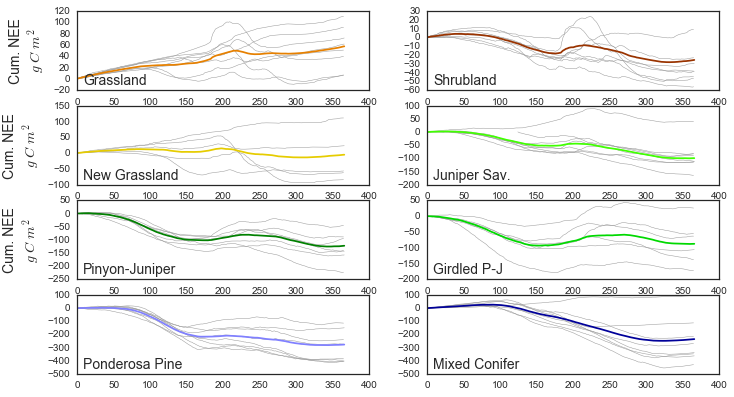

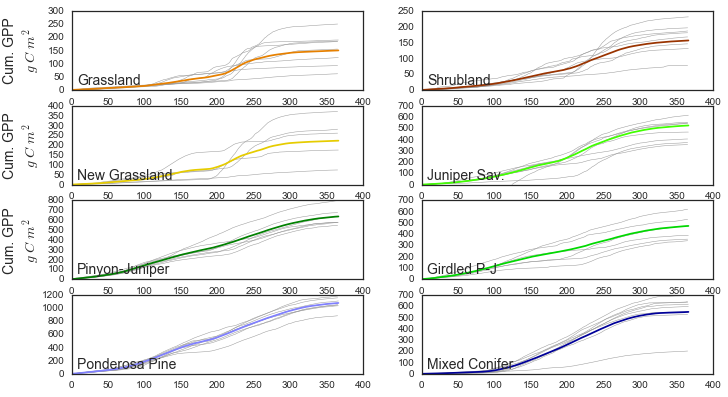

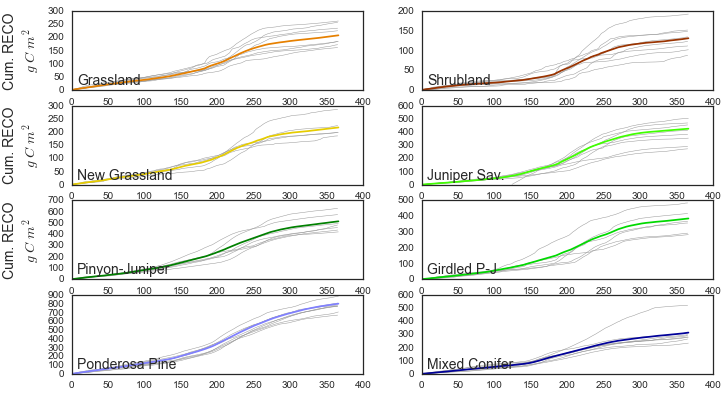

In [30]:
def plot_cumulative_flux( clim, fig, label ):
    ax = list();
    for i, site in enumerate(sites):
        ax.append(fig.add_subplot(len(sites)/2, 2, i+1))
        for j in range(start, end):
            sitedat = clim[site]
            plt.plot( sitedat.index,  np.cumsum(sitedat[str(j)]), color='0.6', lw=0.5)
        plt.plot( clim[site].index,  np.cumsum(clim[site].allyr_mean), color=nmegplt.palette[site])
            
        #plt.xlim( xlims )
        plt.text( .02, .07, nmegplt.longnames[site], size=14, transform=ax[i].transAxes )
        
    for i in (0, 2, 4):
            ax[i].set_ylabel('Cum. {0}\n$g\ C\ m^2$'.format(label), fontsize=14)
            
figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_flux( fc_clim, figX, 'NEE' )

figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_flux( gpp_clim, figY, 'GPP' )

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_flux( re_clim, figZ, 'RECO' )